In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.get_device_name(0))
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


NVIDIA GeForce RTX 2080 SUPER


# Load FashionMNIST Data

In [3]:
fashion_train = datasets.FashionMNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

fashion_test = datasets.FashionMNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 128
train_loader  = torch.utils.data.DataLoader(dataset=fashion_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_batch_size = 32
test_loader = torch.utils.data.DataLoader(dataset=fashion_test,
                                         batch_size=test_batch_size,
                                         shuffle=False)

In [5]:
train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

# Train Base Model

In [6]:
from models import Net, get_resnet18_MNIST

# ResNet18 for MNIST & FashionMNIST
model = get_resnet18_MNIST().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
from attacks import fgsm_attack

num_epochs = 10

for epoch in range(num_epochs):

    total_batch = len(fashion_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        # batch_perturbations = fgsm_attack(batch_images, batch_labels).cuda()

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        outputs = model(X)
        loss = criterion(outputs, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [%d/%d], Loss: %.4f'
        %(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 0.2606
Epoch [2/10], Loss: 0.2303
Epoch [3/10], Loss: 0.1618
Epoch [4/10], Loss: 0.1346
Epoch [5/10], Loss: 0.1147
Epoch [6/10], Loss: 0.1371
Epoch [7/10], Loss: 0.0842
Epoch [8/10], Loss: 0.1191
Epoch [9/10], Loss: 0.0689
Epoch [10/10], Loss: 0.0605


In [8]:
torch.save(model.state_dict(), 'models/FashionMNIST_ResNet18.pth')

## Standard Testing

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)

        outputs = model(data)

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy {100 * correct // total} %')

Accuracy 89 %


# Adversarial Attack - Robust Accuracy

In [10]:
from attacks import test_robustness

# eps = 0 means no attack
epsilons = [0, .05, .1, .15, .2, .25, .3]

# accuracies of each eps test
accuracies = []

# resulting adversarial examples
examples = []

# generated perturbations
perturbations = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex, adv_per = test_robustness(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    perturbations.append(adv_per)

Epsilon: 0	Test Accuracy = 8916 / 10000 = 0.8916
Epsilon: 0.05	Test Accuracy = 4639 / 10000 = 0.4639
Epsilon: 0.1	Test Accuracy = 3215 / 10000 = 0.3215
Epsilon: 0.15	Test Accuracy = 2581 / 10000 = 0.2581
Epsilon: 0.2	Test Accuracy = 2196 / 10000 = 0.2196
Epsilon: 0.25	Test Accuracy = 1944 / 10000 = 0.1944
Epsilon: 0.3	Test Accuracy = 1782 / 10000 = 0.1782


## Visualizaing Learned Perturbations 

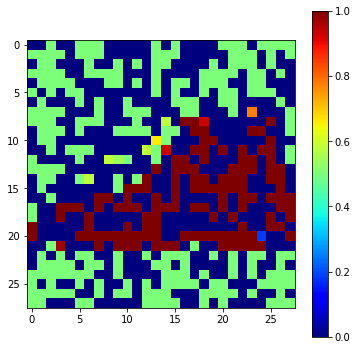

In [11]:
original_img = examples[1][1][3][0][0].squeeze().detach().cpu().numpy()
adv_img = examples[1][1][2][0]

diff = original_img - adv_img
diff = (diff - diff.min()) / (diff.max() - diff.min())
plt.figure(figsize=(6,6))
plt.imshow(diff, cmap='jet')
plt.colorbar()
plt.show()

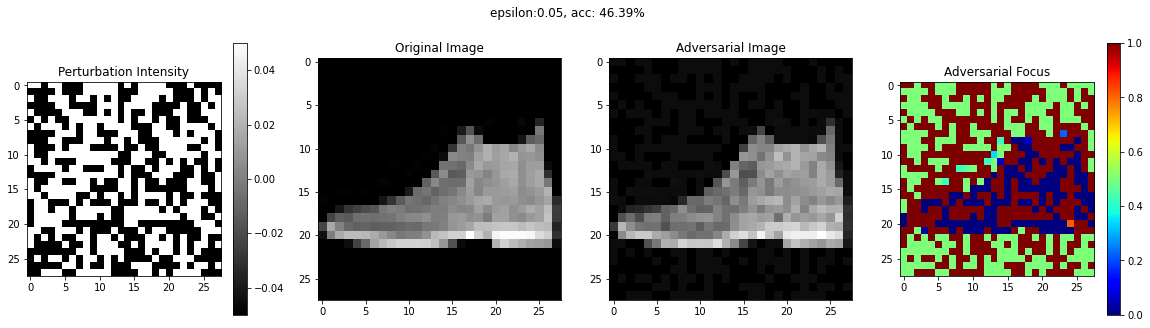

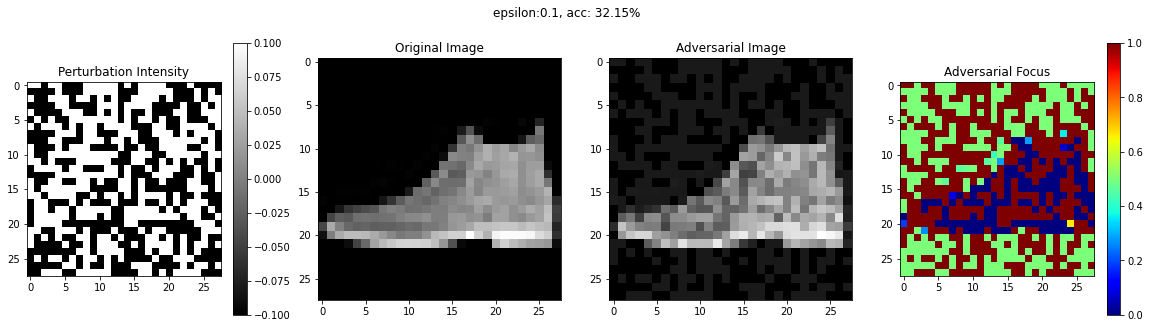

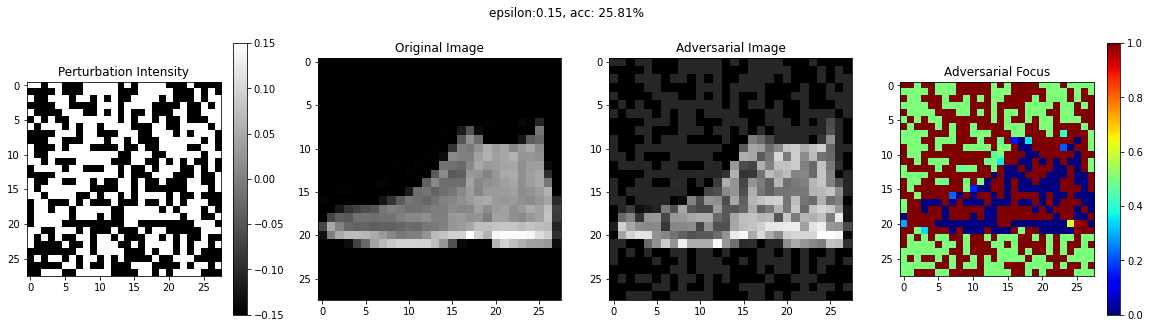

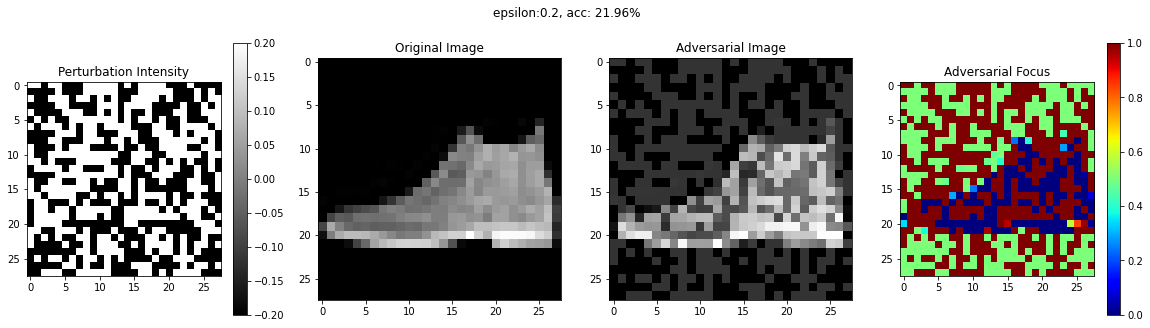

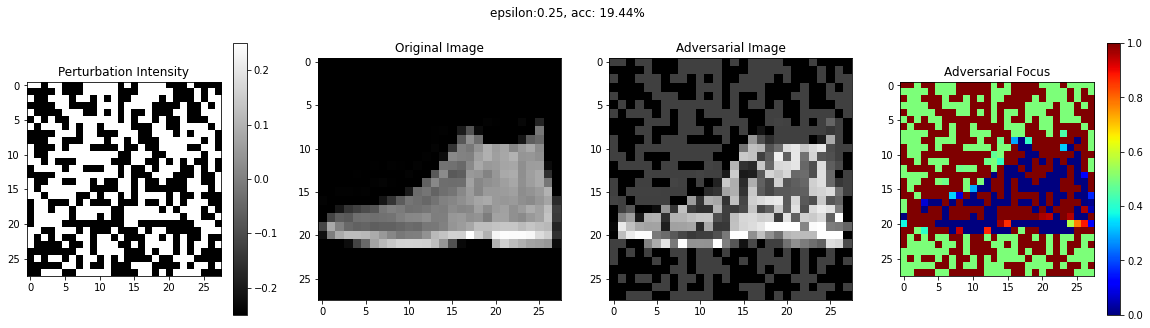

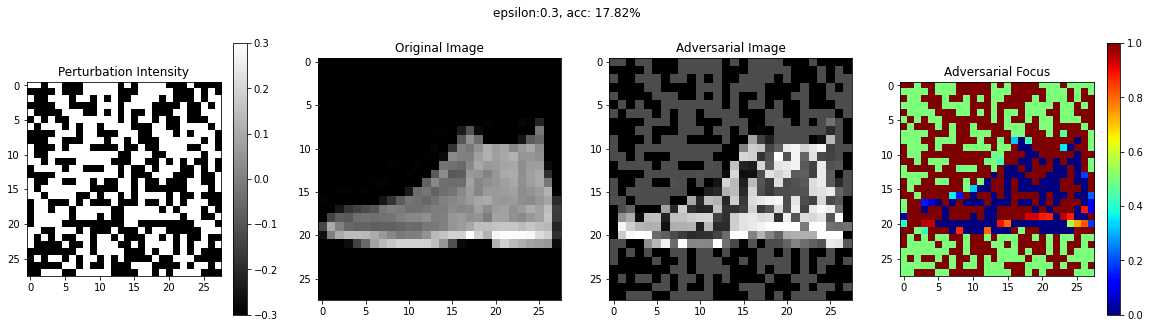

In [12]:
for e, e_value in enumerate(epsilons):
    if e == 0: continue
    
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"epsilon:{e_value}, acc: {np.round(accuracies[e] * 100, 4)}%")
    i = 1
    plt.subplot(1,4,1)
    p = perturbations[e][i][0][0].squeeze().detach().cpu().numpy()
    plt.imshow(p, cmap="gray")
    plt.title(f"Perturbation Intensity")
    plt.colorbar()

    plt.subplot(1,4,2)
    original_img = examples[e][i][3][0][0].squeeze().detach().cpu().numpy()
    plt.imshow(original_img, cmap="gray")
    plt.title("Original Image")


    plt.subplot(1,4,3)
    adv_img = examples[e][i][2][0]
    plt.imshow(adv_img, cmap="gray")
    plt.title("Adversarial Image")

    plt.subplot(1,4, 4)
    diff = adv_img - original_img
    # MinMax Scaling [0,1]
    diff = (diff - diff.min()) / (diff.max() - diff.min())
    plt.imshow(diff, cmap='jet')
    plt.colorbar()
    plt.title("Adversarial Focus")
    plt.show();


## Transfer Robustness via Adversarial Perturbations

In [13]:
mnist_train = datasets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = datasets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [14]:
train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=test_batch_size,
                                         shuffle=False)

# MNIST Model

## NO Perturbation Added (Baseline)

In [15]:
# ResNet18 for MNIST
model_A = get_resnet18_MNIST().cuda()
criterion_A = nn.CrossEntropyLoss()
optimizer_A = optim.Adam(model_A.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        outputs = model_A(X)
        loss = criterion_A(outputs, Y)

        optimizer_A.zero_grad()
        loss.backward()
        optimizer_A.step()

    print('Epoch [%d/%d], Loss: %.4f'
        %(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 0.2055
Epoch [2/10], Loss: 0.1581
Epoch [3/10], Loss: 0.1299
Epoch [4/10], Loss: 0.1577
Epoch [5/10], Loss: 0.1406
Epoch [6/10], Loss: 0.1611
Epoch [7/10], Loss: 0.1065
Epoch [8/10], Loss: 0.1253
Epoch [9/10], Loss: 0.0964
Epoch [10/10], Loss: 0.1055


In [16]:
torch.save(model_A.state_dict(), 'models/MNIST_ResNet18_baseline.pth')

In [17]:
# eps = 0 means no attack
epsilons = [0, .05, .1, .15, .2, .25, .3]

# accuracies of each eps test
accuracies_A = []

# Run test for each epsilon
for eps in epsilons:
    acc, _, _ = test_robustness(model_A, device, test_loader, eps)
    accuracies_A.append(acc)

Epsilon: 0	Test Accuracy = 9885 / 10000 = 0.9885
Epsilon: 0.05	Test Accuracy = 8978 / 10000 = 0.8978
Epsilon: 0.1	Test Accuracy = 7189 / 10000 = 0.7189
Epsilon: 0.15	Test Accuracy = 5492 / 10000 = 0.5492
Epsilon: 0.2	Test Accuracy = 4264 / 10000 = 0.4264
Epsilon: 0.25	Test Accuracy = 3545 / 10000 = 0.3545
Epsilon: 0.3	Test Accuracy = 3089 / 10000 = 0.3089


## With Perturbation Data Augmentation on Training (Our Proposal)

### Preproccess perturbation

In [18]:
# remove first batch of perturbation due to unexisting perturbation when EPS = 0
perturbations.pop(0);

In [29]:
len(epsilons)

7

In [19]:
# function to get a random perturbation give a eps size
def get_perturbation(perturbation_list, N, eps_index = 0):
    selected_p_index = np.random.randint(N)
    p = perturbation_list[eps_index][selected_p_index][0][0]
    # plt.imshow(p.squeeze().detach().cpu().numpy(), cmap='jet')
    # plt.colorbar()
    return p

### Train with Perturbations

In [32]:
# ResNet18 for MNIST
model_B = get_resnet18_MNIST().cuda()
criterion_B = nn.CrossEntropyLoss()
optimizer_B = optim.Adam(model_B.parameters(), lr=0.001)

N = 500 # number of pertubations set
num_epochs = 10

for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        # eps_index is a hyperparameter
        p = get_perturbation(perturbations, N, eps_index = np.random.randint(len(epsilons) - 1))
        X = torch.add(X, p)

        outputs = model_B(X)
        loss = criterion_B(outputs, Y)

        optimizer_B.zero_grad()
        loss.backward()
        optimizer_B.step()

    print('Epoch [%d/%d], Loss: %.4f'
        %(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 0.1997
Epoch [2/10], Loss: 0.1490
Epoch [3/10], Loss: 0.1533
Epoch [4/10], Loss: 0.1335
Epoch [5/10], Loss: 0.1199
Epoch [6/10], Loss: 0.1063
Epoch [7/10], Loss: 0.1429
Epoch [8/10], Loss: 0.1091
Epoch [9/10], Loss: 0.1223
Epoch [10/10], Loss: 0.1023


In [33]:
torch.save(model_B.state_dict(), 'models/MNIST_ResNet18_robust.pth')

In [34]:
# eps = 0 means no attack
epsilons = [0, .05, .1, .15, .2, .25, .3]

# accuracies of each eps test
accuracies_B = []

# Run test for each epsilon
for eps in epsilons:
    acc, _, _ = test_robustness(model_B, device, test_loader, eps)
    accuracies_B.append(acc)

Epsilon: 0	Test Accuracy = 9850 / 10000 = 0.985
Epsilon: 0.05	Test Accuracy = 9397 / 10000 = 0.9397
Epsilon: 0.1	Test Accuracy = 8312 / 10000 = 0.8312
Epsilon: 0.15	Test Accuracy = 6921 / 10000 = 0.6921
Epsilon: 0.2	Test Accuracy = 5561 / 10000 = 0.5561
Epsilon: 0.25	Test Accuracy = 4512 / 10000 = 0.4512
Epsilon: 0.3	Test Accuracy = 3726 / 10000 = 0.3726


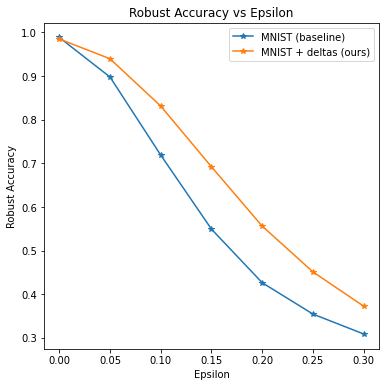

In [35]:
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies_A, "*-", label = "MNIST (baseline)")
plt.plot(epsilons, accuracies_B, "*-", label = "MNIST + deltas (ours)")
plt.title("Robust Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Robust Accuracy")
plt.legend()
plt.show()

# *TODO*: GradCam

In [ ]:
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# input_tensor = test_loader.dataset[0][0]
# # input_tensor = .
# input_tensor = input_tensor.reshape(1, 1, 28, 28)
# input_tensor.shape

In [ ]:
# target_layers = [model.layer4[-1]] # for ResNet18 and ResNet50

# cam = GradCAM(model=model, target_layers=target_layers, use_cuda = True)

# targets = [ClassifierOutputTarget(1)]

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
# grayscale_cam = grayscale_cam[0, :]

In [ ]:
# visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

In [ ]:
# plt.imshow(grayscale_cam, cmap='jet')
# plt.colorbar()
# plt.show()